<a href="https://colab.research.google.com/github/HKLeeeee/AI_proj_Team2/blob/main/Hyper_parameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

# from tensorflow.keras.applications import Densnet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow.keras as keras
from tensorflow.data import Dataset

from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-05-13 22:06:29.113157: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from tensorflow.keras.applications import *

# Data Load

- PREPROCESSING ~~ : dacon 코드 공유 기반으로 저장한 512X512 이미지들


In [3]:
## 경로 설정
small_train_images_path = './data/PREPROCESSING-TRAIN'
small_test_images_path = './data/PREPROCESSING-TEST'
data_path = './data'

- *_images_name : 이미지 파일들 이름
- *_images_path : 이미지 파일 경로

In [4]:
train_images_name = sorted(os.listdir(small_train_images_path))
train_images_path = \
[os.path.join(small_train_images_path, name) for name in train_images_name]

test_images_name = sorted(os.listdir(small_test_images_path))
test_images_path = \
[os.path.join(small_test_images_path, name) for name in test_images_name]

In [5]:
train_images_name[0]

'CASE01_01.png'

In [6]:
train_images_path[0]

'./data/PREPROCESSING-TRAIN/CASE01_01.png'

label 불러오기

In [7]:
label_dfs = []
case_names = sorted(os.listdir('./data/train'))

for case in case_names :
    label_path = data_path+'/train/'+case+'/label-{}.csv'.format(str(int(case[-2:])))
    df = pd.read_csv(label_path)
    label_dfs.append(df)
    
label_df = pd.concat(label_dfs, axis=0)
label_df.to_csv('./data/labels.csv', index=False)

In [8]:
label_df.head()

,img_name,leaf_weight
0,CASE01_01.png,49.193
1,CASE01_02.png,59.764
2,CASE01_03.png,72.209
3,CASE01_04.png,85.737
4,CASE01_05.png,102.537


data 순서 shuffle

In [9]:
label_df.set_index('img_name', inplace=True)
label_df.head()

,leaf_weight
img_name,
CASE01_01.png,49.193
CASE01_02.png,59.764
CASE01_03.png,72.209
CASE01_04.png,85.737
CASE01_05.png,102.537


In [10]:
label_df['img_path'] = train_images_path
label_df.head()

,leaf_weight,img_path
img_name,,
CASE01_01.png,49.193,./data/PREPROCESSING-TRAIN/CASE01_01.png
CASE01_02.png,59.764,./data/PREPROCESSING-TRAIN/CASE01_02.png
CASE01_03.png,72.209,./data/PREPROCESSING-TRAIN/CASE01_03.png
CASE01_04.png,85.737,./data/PREPROCESSING-TRAIN/CASE01_04.png
CASE01_05.png,102.537,./data/PREPROCESSING-TRAIN/CASE01_05.png


In [11]:
shuffled_df = label_df.sample(frac=1)
shuffled_df.head()

,leaf_weight,img_path
img_name,,
CASE08_02.jpg,0.869,./data/PREPROCESSING-TRAIN/CASE08_02.jpg
CASE67_04.png,3.002,./data/PREPROCESSING-TRAIN/CASE67_04.png
CASE04_04.png,110.563,./data/PREPROCESSING-TRAIN/CASE04_04.png
CASE13_16.png,17.620,./data/PREPROCESSING-TRAIN/CASE13_16.png
CASE45_10.png,16.106,./data/PREPROCESSING-TRAIN/CASE45_10.png


In [12]:
len(shuffled_df)

1592

# Data Generator

In [13]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(shuffled_df)*0.8)

train_df = shuffled_df[:train_len]
valid_df = shuffled_df[train_len:]

train_img_path = train_df['img_path'].to_list()
train_label = train_df['leaf_weight'].to_list()

valid_img_path = valid_df['img_path'].to_list()
valid_label = valid_df['leaf_weight'].to_list()

In [14]:
train_df

,leaf_weight,img_path
img_name,,
CASE08_02.jpg,0.869,./data/PREPROCESSING-TRAIN/CASE08_02.jpg
CASE67_04.png,3.002,./data/PREPROCESSING-TRAIN/CASE67_04.png
CASE04_04.png,110.563,./data/PREPROCESSING-TRAIN/CASE04_04.png
CASE13_16.png,17.620,./data/PREPROCESSING-TRAIN/CASE13_16.png
CASE45_10.png,16.106,./data/PREPROCESSING-TRAIN/CASE45_10.png
...,...,...
CASE39_28.png,302.911,./data/PREPROCESSING-TRAIN/CASE39_28.png
CASE45_16.png,41.239,./data/PREPROCESSING-TRAIN/CASE45_16.png
CASE26_09.png,6.736,./data/PREPROCESSING-TRAIN/CASE26_09.png


In [15]:
%%time
train_img = np.array(list(map(cv2.imread, train_img_path)))
valid_img = np.array(list(map(cv2.imread, valid_img_path)))

CPU times: user 8.72 s, sys: 909 ms, total: 9.63 s
Wall time: 10.9 s


In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=10,
                                 shear_range=0.1,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode = 'nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
BATCH_SIZE = 19

train_generator = train_datagen.flow(train_img,
                                    train_label,
                                    batch_size=BATCH_SIZE)

valid_generator = test_datagen.flow(valid_img,
                                    valid_label,
                                   batch_size=BATCH_SIZE)

Labels:  [1.953, 51.655, 190.768, 61.451, 42.927]


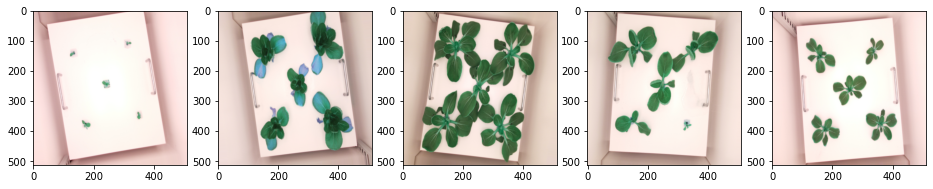

In [20]:
test = [next(train_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16,6))

print('Labels: ', [item[1][0] for item in test])
l = [ax[i].imshow(test[i][0][0]) for i in range(0,5)]

Labels:  [88.734, 48.375, 12.138, 2.861, 204.018]


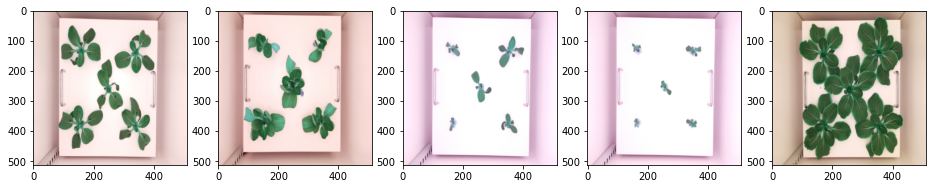

In [21]:
test = [next(valid_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16,6))

print('Labels: ', [item[1][0] for item in test])
l = [ax[i].imshow(test[i][0][0]) for i in range(0,5)]

# Definitions

In [29]:
def NMAE(y_true, y_pred) :
    error = y_true - y_pred
    absolute_error = tf.abs(error)
    return tf.reduce_mean(absolute_error) / tf.reduce_mean(y_true)

In [39]:
def nmae(y_true, y_pred):
    score = tf.py_function(func=NMAE, inp=[y_true, y_pred], Tout=tf.float32, name='nmae')
    return score

In [55]:
IMAGE_SIZE = 512
def bulid_model(hyper_params : tuple) :
    pretrain_net, learning_rate, opti, dropout = hyper_params

    if pretrain_net == 'resnet50' :
        MODEL_IMAGE_SIZE = 224
        base_model = resnet50.ResNet50(
        weights='imagenet',
        include_top = False,
        input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
        )
    elif pretrain_net == 'inception_v2_resnet':
        MODEL_IMAGE_SIZE = 299
        base_model = inception_resnet_v2.InceptionResNetV2(
            weights='imagenet',
            include_top = False,
            input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
        )
    elif pretrain_net == 'efficientnet_b4' :
        MODEL_IMAGE_SIZE = 380
        base_model = inception_resnet_v2.InceptionResNetV2(
        weights='imagenet',
        include_top = False,
        input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
        )
    base_model.trainable=False

    input_data = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
    x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
    resizing = Model(inputs=input_data, outputs=x, name='resize')

    inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
    x = resizing(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(1, activation='relu')(x)
    model = Model(inputs, outputs)

    optimizer = None 
    if opti == 'adam' :
        optimizer = Adam(learning_rate)
    elif opti == 'rmsprop' :
        optimizer = RMSprop(learning_rate)
    elif opti == 'nadam' :
        optimizer = Nadam(learning_rate)


    model.compile(optimizer=optimizer,
                loss='mae',
                metrics=[nmae])

    return model

In [48]:
def fit_model(model=None, early_stop = True, epoch=100, ckpt_path=None, save_best_only=True, 
              save_weights_only=True) :
    es = EarlyStopping(monitor='loss',
                    mode='auto',
                    patience=5,
                    verbose=1)

    checkpointer = ModelCheckpoint(filepath=ckpt_path,
                                  monitor='val_nmae',
                                  save_weights_only = save_weights_only,
                                  save_best_only= save_best_only,
                                  verbose=1)

    call_backs = [checkpointer]
    if early_stop :
        call_backs.append(es)

    STEPS_PER_EPOCH = len(train_img) // BATCH_SIZE
    VAL_STEPS = len(valid_img) // BATCH_SIZE
    history = model.fit(train_generator, epochs=epoch,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=valid_generator,
                      validation_steps = VAL_STEPS,
                      callbacks=call_backs,
                      verbose=1)
    return history

In [56]:
def draw_graph(title) :
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.legend(loc='upper right')
    ax1.set_title('MAE : '+title)
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(history.history['nmae'], label='Training NMAE')
    ax2.plot(history.history['val_nmae'], label='Validation NMAE')
    ax2.legend(loc='upper right')
    ax2.set_title('NMAE : '+title)
    
    plt.savefig('./Training_Result/'+title+'.png')  ## 그래프 이미지 저장 경로
    plt.show()

# Parameters

In [57]:
PARAMS = {
    'pretrain_net' : ['resnet50', 'inception_v2_resnet'], 
    'learning rate' : [1e-2, 1e-3, 1e-4, 1e-5],
    'optimizer' : ['adam', 'rmsprop', 'nadam'],
    'dropout' : [0.2, 0.5]
}

In [58]:
hyper_params=list(product(PARAMS['pretrain_net'], PARAMS['learning rate'],PARAMS['optimizer'],PARAMS['dropout']))

# Train

In [59]:
history_dict = {'min_nmae' : 9999,
                'min_nmae_param' : '',
                'min_val_nmae' : 9999,
                'min_val_nmae_param' : '',
                'min_mae' : 9999,
                'min_mae_param' : '',
                'min_val_mae' : 9999,
                'min_val_mae_param' : ''}

Epoch 1/2
67/67 [==============================] - 67s 967ms/step - loss: 53.4116 - nmae: 0.6775 - val_loss: 46.3597 - val_nmae: 0.5360

Epoch 00001: val_nmae improved from inf to 0.53605, saving model to ./Check_Point/resnet50 0.01 adam 0.2-best_weights.ckpt
Epoch 2/2
67/67 [==============================] - 64s 956ms/step - loss: 41.0437 - nmae: 0.5161 - val_loss: 41.1539 - val_nmae: 0.4576

Epoch 00002: val_nmae improved from 0.53605 to 0.45762, saving model to ./Check_Point/resnet50 0.01 adam 0.2-best_weights.ckpt


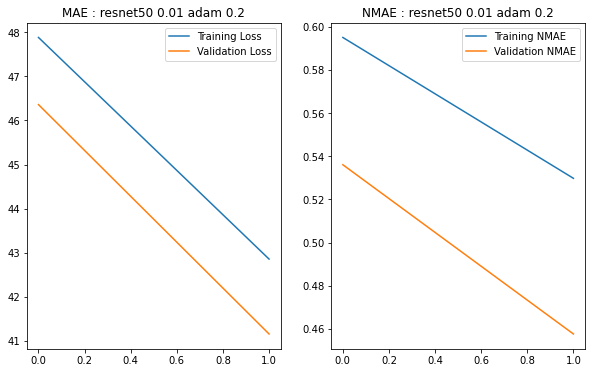

Epoch 1/2
67/67 [==============================] - 67s 971ms/step - loss: 54.2722 - nmae: 0.6824 - val_loss: 48.8047 - val_nmae: 0.5336

Epoch 00001: val_nmae improved from inf to 0.53358, saving model to ./Check_Point/resnet50 0.01 adam 0.5-best_weights.ckpt
Epoch 2/2
67/67 [==============================] - 64s 957ms/step - loss: 48.4378 - nmae: 0.5698 - val_loss: 49.3380 - val_nmae: 0.5525

Epoch 00002: val_nmae did not improve from 0.53358


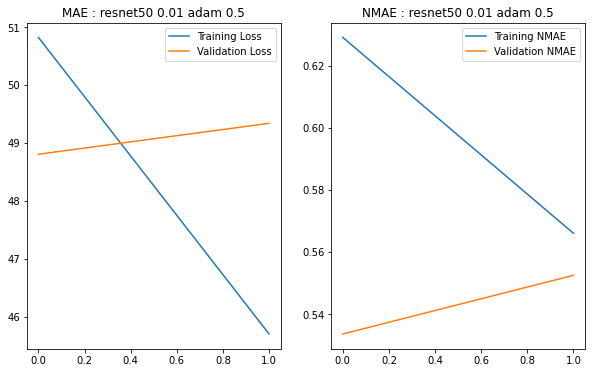

In [66]:
i=0
for params in hyper_params :
    tf.keras.backend.clear_session()
    key = ' '.join(map(str, params))
    model = bulid_model(params)
    history = fit_model(model=model,
                      epoch=2,
                      ckpt_path='./Check_Point/{}-best_weights.ckpt'.format(key))  #### 체크포인트 저장 경로
    if min(history.history['nmae']) < history_dict['min_nmae'] :
        history_dict['min_nmae'] = min(history.history['nmae'])
        history_dict['min_nmae_param'] = key

    if min(history.history['val_nmae']) < history_dict['min_val_nmae'] :
        history_dict['min_val_nmae'] = min(history.history['val_nmae'])
        history_dict['min_val_nmae_param'] = key
    
    if min(history.history['loss']) < history_dict['min_mae'] :
        history_dict['min_mae'] = min(history.history['loss'])
        history_dict['min_mae_param'] = key

    if min(history.history['val_loss']) < history_dict['min_val_mae'] :
        history_dict['min_val_mae'] = min(history.history['val_loss'])
        history_dict['min_val_mae_param'] = key
    draw_graph(key)
    i+=1
    if i==2 :
        break

In [61]:
history_dict

{'min_nmae': 0.5331358909606934,
 'min_nmae_param': 'resnet50 0.01 adam 0.2',
 'min_val_nmae': 0.4548892378807068,
 'min_val_nmae_param': 'resnet50 0.01 adam 0.2',
 'min_mae': 9999,
 'min_mae_param': '',
 'min_val_mae': 9999,
 'min_val_mae_param': ''}

CODE TEST

Epoch 1/10
67/67 [==============================] - 78s 1s/step - loss: 73.7925 - mae: 73.7925 - val_loss: 60.0900 - val_mae: 60.0900

Epoch 00001: val_mae improved from inf to 60.09002, saving model to ./inception_v2_resnet 0.0001 adam mae 0.2-best_weights_test.ckpt
Epoch 2/10
67/67 [==============================] - 66s 988ms/step - loss: 57.7470 - mae: 57.7470 - val_loss: 49.3713 - val_mae: 49.3713

Epoch 00002: val_mae improved from 60.09002 to 49.37126, saving model to ./inception_v2_resnet 0.0001 adam mae 0.2-best_weights_test.ckpt
Epoch 3/10
67/67 [==============================] - 67s 990ms/step - loss: 44.3482 - mae: 44.3482 - val_loss: 40.8661 - val_mae: 40.8661

Epoch 00003: val_mae improved from 49.37126 to 40.86605, saving model to ./inception_v2_resnet 0.0001 adam mae 0.2-best_weights_test.ckpt
Epoch 4/10
67/67 [==============================] - 67s 996ms/step - loss: 32.2810 - mae: 32.2810 - val_loss: 30.6021 - val_mae: 30.6021

Epoch 00004: val_mae improved from 40.8660

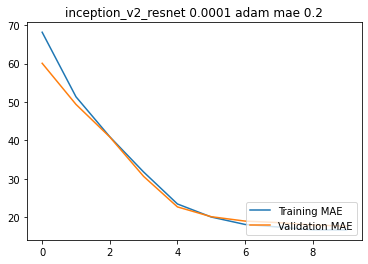

In [29]:
params = ('inception_v2_resnet', 1e-4, 'adam', 'mae', 0.2)
key = ' '.join(map(str, params))
model = bulid_model(params)
history = fit_model(model=model,
                  epoch=10,
                  ckpt_path='./{}-best_weights_test.ckpt'.format(key))  #### 체크포인트 저장 경로
if min(history.history['mae']) < history_dict['min_mae'] :
    history_dict['min_mae'] = min(history.history['mae'])
    history_dict['min_mae_param'] = key

if min(history.history['val_mae']) < history_dict['min_val_mae'] :
    history_dict['min_val_mae'] = min(history.history['val_mae'])
    history_dict['min_val_mae_param'] = key

draw_graph(key)

In [61]:
MODEL_IMAGE_SIZE = 299
base_model = inception_resnet_v2.InceptionResNetV2(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
)

base_model.trainable=False

input_data = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
resizing = Model(inputs=input_data, outputs=x, name='resize')

inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = resizing(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(1, activation='relu')(x)
model = Model(inputs, outputs)

optimizer = Adam(1e-4)

model.compile(optimizer=optimizer,
            loss='mae',
            metrics=['mae'])

In [98]:
model.load_weights('./inception_v2_resnet 0.0001 adam mae 0.2-best_weights_test.ckpt')

In [99]:
# 전이 학습 단계 추가 학습
base_model.trainable=False

optimizer = Adam(1e-4)

model.compile(optimizer=optimizer,
            loss='mae',
            metrics=['mae'])

history = fit_model(model=model,
                  epoch=10,
                  ckpt_path='./{}-best_weights_test_2.ckpt'.format(key))  #### 체크포인트 저장 경로

Epoch 1/10
67/67 [==============================] - 76s 1s/step - loss: 16.6648 - mae: 16.6648 - val_loss: 17.0844 - val_mae: 17.0844

Epoch 00001: val_mae improved from inf to 17.08437, saving model to ./inception_v2_resnet 0.0001 adam mae 0.2-best_weights_test_2.ckpt
Epoch 2/10
67/67 [==============================] - 66s 987ms/step - loss: 16.0852 - mae: 16.0852 - val_loss: 16.3375 - val_mae: 16.3375

Epoch 00002: val_mae improved from 17.08437 to 16.33752, saving model to ./inception_v2_resnet 0.0001 adam mae 0.2-best_weights_test_2.ckpt
Epoch 3/10
67/67 [==============================] - 67s 992ms/step - loss: 15.5572 - mae: 15.5572 - val_loss: 16.8734 - val_mae: 16.8734

Epoch 00003: val_mae did not improve from 16.33752
Epoch 4/10
67/67 [==============================] - 67s 991ms/step - loss: 15.5134 - mae: 15.5134 - val_loss: 16.5837 - val_mae: 16.5837

Epoch 00004: val_mae did not improve from 16.33752
Epoch 5/10
67/67 [==============================] - 66s 986ms/step - loss:

In [101]:
model.load_weights('./inception_v2_resnet 0.0001 adam mae 0.2-best_weights_test_2.ckpt')
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.9)
for layer in base_model.layers[:fine_tune_at] :
    layer.trainable = False

In [102]:
optimizer = Adam(1e-5)

model.compile(optimizer=optimizer,
            loss='mae',
            metrics=['mae'])

history = fit_model(model=model,
                  epoch=10,
                  ckpt_path='./{}-best_weights_test_2_fine.ckpt'.format(key))  #### 체크포인트 저장 경로

Epoch 1/10
67/67 [==============================] - 77s 1s/step - loss: 13.7963 - mae: 13.7963 - val_loss: 12.6432 - val_mae: 12.6432

Epoch 00001: val_mae improved from inf to 12.64320, saving model to ./inception_v2_resnet 0.0001 adam mae 0.2-best_weights_test_2_fine.ckpt
Epoch 2/10
67/67 [==============================] - 66s 984ms/step - loss: 11.6462 - mae: 11.6462 - val_loss: 12.8474 - val_mae: 12.8474

Epoch 00002: val_mae did not improve from 12.64320
Epoch 3/10
67/67 [==============================] - 66s 988ms/step - loss: 9.9262 - mae: 9.9262 - val_loss: 10.4476 - val_mae: 10.4476

Epoch 00003: val_mae improved from 12.64320 to 10.44758, saving model to ./inception_v2_resnet 0.0001 adam mae 0.2-best_weights_test_2_fine.ckpt
Epoch 4/10
67/67 [==============================] - 66s 989ms/step - loss: 9.1325 - mae: 9.1325 - val_loss: 10.0759 - val_mae: 10.0759

Epoch 00004: val_mae improved from 10.44758 to 10.07592, saving model to ./inception_v2_resnet 0.0001 adam mae 0.2-best

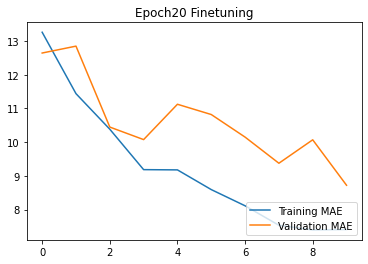

In [103]:
draw_graph('Epoch20 Finetuning')

In [69]:
# 10epoch - finetuning 10 epoch
history = fit_model(model=model,
                  epoch=10,
                  ckpt_path='./{}-best_weights_test_fine.ckpt'.format(key))  #### 체크포인트 저장 경로

Epoch 1/10
67/67 [==============================] - 78s 1s/step - loss: 14.0990 - mae: 14.0990 - val_loss: 13.5005 - val_mae: 13.5005

Epoch 00001: val_mae improved from inf to 13.50049, saving model to ./inception_v2_resnet 0.0001 adam mae 0.2-best_weights_test_fine.ckpt
Epoch 2/10
67/67 [==============================] - 67s 993ms/step - loss: 11.5671 - mae: 11.5671 - val_loss: 11.5234 - val_mae: 11.5234

Epoch 00002: val_mae improved from 13.50049 to 11.52335, saving model to ./inception_v2_resnet 0.0001 adam mae 0.2-best_weights_test_fine.ckpt
Epoch 3/10
67/67 [==============================] - 67s 998ms/step - loss: 10.1641 - mae: 10.1641 - val_loss: 11.1803 - val_mae: 11.1803

Epoch 00003: val_mae improved from 11.52335 to 11.18032, saving model to ./inception_v2_resnet 0.0001 adam mae 0.2-best_weights_test_fine.ckpt
Epoch 4/10
67/67 [==============================] - 67s 998ms/step - loss: 9.0429 - mae: 9.0429 - val_loss: 10.3199 - val_mae: 10.3199

Epoch 00004: val_mae improved

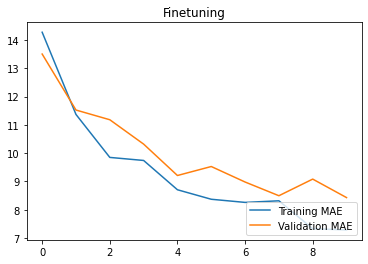

In [70]:
draw_graph_graphph('Finetuning')

## Prediction Test

In [31]:
len(valid_img)

319

In [45]:
PRED_BATCH_SIZE = 10
test_img = np.array(list(map(cv2.imread, test_images_path)))
test_generator = test_datagen.flow(test_img,
                                   shuffle=False,
                                   batch_size=PRED_BATCH_SIZE)

In [104]:
prediction = model.predict(test_generator,
                          steps=len(test_images_path)/PRED_BATCH_SIZE,
                          batch_size = PRED_BATCH_SIZE) 

In [105]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['leaf_weight'] = prediction.squeeze()
submission.to_csv('./data/inception_v2_resnet_cnn_imagedatagenerator_finetuning2.csv', index=False)

In [ ]:
valid_test_generator = test_datagen.flow(valid_img,
                                        shuffle=False,
                                        batch_size=29)
valid_pred = model.predict(valid_test_generator,
                          steps=len(valid_img)/29,
                          batch_size=29)



In [73]:
valid_df

,leaf_weight,img_path,prediction
img_name,,,
CASE49_29.png,65.199,./data/PREPROCESSING-TRAIN/CASE49_29.png,84.139626
CASE35_07.png,6.013,./data/PREPROCESSING-TRAIN/CASE35_07.png,0.000000
CASE62_18.png,51.009,./data/PREPROCESSING-TRAIN/CASE62_18.png,65.372398
CASE33_21.png,286.059,./data/PREPROCESSING-TRAIN/CASE33_21.png,276.309570
CASE35_06.png,4.434,./data/PREPROCESSING-TRAIN/CASE35_06.png,0.000000
...,...,...,...
CASE45_11.png,19.306,./data/PREPROCESSING-TRAIN/CASE45_11.png,24.825262
CASE26_39.png,42.600,./data/PREPROCESSING-TRAIN/CASE26_39.png,64.528679
CASE37_04.png,1.705,./data/PREPROCESSING-TRAIN/CASE37_04.png,0.000000


In [75]:
from sklearn.preprocessing import StandardScaler

def absoulter_error(x, y) :
    return abs(x-y)

y_true = valid_df['leaf_weight'].to_list()
y_pred = valid_df['prediction'].to_list()

AE = list(map(absoulter_error, y_true, y_pred))

In [ ]:
def NMAE(true, pred) :
    ae = list(map(abs, true-pred))

In [80]:
AE = np.array(AE)
AE=AE.reshape(-1,1)

In [81]:
scaler = StandardScaler()
scaler.fit(AE)

StandardScaler()

In [82]:
NAE = scaler.transform(AE)

In [85]:
NAE = NAE.squeeze()

In [86]:
np.mean(NAE)

1.1972310986553413e-16

In [89]:
mean = np.mean(AE.squeeze())

In [92]:
scaler.transform([[mean]])

array([[0.]])

In [95]:
mean / np.mean(y_true)

0.20928863918254434

In [96]:
max(y_true)

444.465

In [97]:
mean / (max(y_true) - min(y_true))

0.039460011410910205